# Comparación Estadística de Tres Técnicas de ML

**Proyecto:** Clasificación Multietiqueta de Señales Sísmicas  
**Modelos comparados:**  
1. Random Forest (`rf_repkfold.pkl`)  
2. Support‑Vector Machine (`svm_repkfold.pkl`)  
3. Red Neuronal (`best_seismic.ckpt` + `scaler.pkl`)

Evaluamos los modelos con **Validación Cruzada Repetida K‑Fold** y comparamos estadísticamente su rendimiento F1‑micro utilizando la prueba de Friedman y las pruebas post‑hoc de rango con signo de Wilcoxon.  
Ajusta `n_repeats` / `k` si el tiempo de entrenamiento es excesivo (valores predeterminados = 2 × 5).

In [ ]:
import os, json, joblib, torch, numpy as np, pandas as pd
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from scipy.stats import friedmanchisquare, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns  # comment out if seaborn is not installed

import lightning as L          # unified Lightning import
import torch.nn as nn
from torchmetrics import F1Score, HammingDistance


In [ ]:
# --- Ensure we are at project root ---
if os.path.basename(os.getcwd()) != 'Seismic-Multilabel-Event-Classifier':
    while os.path.basename(os.getcwd()) != 'Seismic-Multilabel-Event-Classifier':
        os.chdir('..')
    print('CWD ->', os.getcwd())


In [ ]:
# --- Load processed dataset ---
with open('data/processed/dataset_final.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)

label_cols = [
    '1 Stiker Slip (SS)', '2 Normal-Oblique (SO)', '3 Reverse-Oblique (RO)',
    '4-6', '6-8', '0-200', '200-400', '400-600', '600-'
]
feature_cols = [c for c in df.columns if c not in label_cols]

X = df[feature_cols].to_numpy(dtype='float32')
y = df[label_cols].astype(int).to_numpy()

print('Dataset:', X.shape, y.shape)

Dataset: (1674, 82) (1674, 9)


In [ ]:
# --- Lightning model ---
class SeismicMultilabelModel(L.LightningModule):
    """Simple MLP for multilabel seismic classification."""
    def __init__(self,
                 input_dim:int,
                 num_classes:int,
                 hidden_units=(128, 64),
                 lambda_L2:float=0.0,
                 lr:float=1e-3):
        super().__init__()
        self.save_hyperparameters()

        layers = [nn.Flatten()]
        prev = input_dim
        for h in hidden_units:
            layers += [nn.Linear(prev, h), nn.ReLU()]
            prev = h
        layers.append(nn.Linear(prev, num_classes))

        self.model = nn.Sequential(*layers)
        self.classifier = self.model        # alias for checkpoint compatibility

        self.crit = nn.BCEWithLogitsLoss()
        self.f1   = F1Score(task='multilabel', num_labels=num_classes,
                            average='micro')
        self.ham  = HammingDistance(task='multilabel', num_labels=num_classes)

    # forward pass
    def forward(self, x): return self.model(x)

    # shared logic
    def _step(self, batch, stage:str):
        x, y = batch
        logits = self(x)
        loss = self.crit(logits, y.float())
        probs = torch.sigmoid(logits)
        self.log(f'{stage}_loss', loss, prog_bar=True)
        self.log(f'{stage}_f1',   self.f1(probs, y), prog_bar=True)
        self.log(f'{stage}_ham',  self.ham(probs, y), prog_bar=True)
        return loss

    def training_step(self, batch, idx):   return self._step(batch, 'train')
    def validation_step(self, batch, idx): return self._step(batch, 'val')
    def test_step(self, batch, idx):       return self._step(batch, 'test')

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.lambda_L2)


In [ ]:
# --- Helper to train NN inside a CV fold ---
from torch.utils.data import DataLoader, TensorDataset

def train_nn(X_tr, y_tr, X_val, y_val, hparams, epochs=15):
    scaler = StandardScaler().fit(X_tr)
    Xtr = torch.tensor(scaler.transform(X_tr), dtype=torch.float32)
    Xv  = torch.tensor(scaler.transform(X_val), dtype=torch.float32)
    ytr = torch.tensor(y_tr, dtype=torch.float32)
    yv  = torch.tensor(y_val, dtype=torch.float32)

    train_dl = DataLoader(TensorDataset(Xtr, ytr), batch_size=32, shuffle=True)
    val_dl   = DataLoader(TensorDataset(Xv,  yv),  batch_size=32)

    model = SeismicMultilabelModel(
        input_dim   = X_tr.shape[1],
        num_classes = y_tr.shape[1],
        hidden_units= hparams['hidden_units'],
        lambda_L2   = hparams['lambda_L2'],
        lr          = hparams['lr']
    )

    trainer = L.Trainer(max_epochs=epochs,
                        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                        devices=1,
                        logger=False,
                        enable_progress_bar=False,
                        enable_checkpointing=False)

    trainer.fit(model, train_dl, val_dl)
    return model, scaler


In [ ]:
# --- Load RF & SVM templates ---
rf_template  = joblib.load('models/rf_repkfold.pkl')
svm_template = joblib.load('models/svm_repkfold.pkl')

def make_model(estimator):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clone(estimator))
    ])

rf_pipe  = make_model(rf_template)
svm_pipe = make_model(svm_template)

# Hyperparameters for NN (same as checkpoint best)
hparams = dict(hidden_units=(128,64), lambda_L2=0.0, lr=1e-3)


In [ ]:
# --- Repeated K‑Fold evaluation ---
n_splits, n_repeats = 5, 2
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

rf_scores, svm_scores, nn_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(rkf.split(X), 1):
    print(f'Fold {fold}/{n_splits*n_repeats}')
    X_tr, y_tr = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    # Random Forest
    rf = clone(rf_pipe)
    rf.fit(X_tr, y_tr)
    rf_scores.append(f1_score(y_val, rf.predict(X_val), average='micro'))

    # SVM
    svm = clone(svm_pipe)
    svm.fit(X_tr, y_tr)
    svm_scores.append(f1_score(y_val, svm.predict(X_val), average='micro'))

    # Neural Net
    nn_model, scaler_fold = train_nn(X_tr, y_tr, X_val, y_val, hparams, epochs=15)
    X_val_scaled = scaler_fold.transform(X_val)
    with torch.no_grad():
        logits = nn_model(torch.tensor(X_val_scaled, dtype=torch.float32))
        probs  = torch.sigmoid(logits).cpu().numpy()
    nn_scores.append(f1_score(y_val, (probs > 0.5).astype(int), average='micro'))

# Collect scores
df_scores = pd.DataFrame({
    'RandomForest': rf_scores,
    'SVM':          svm_scores,
    'NeuralNet':    nn_scores
})
df_scores.head()


       RandomForest        SVM  NeuralNet
count     10.000000  10.000000  10.000000
mean       0.608415   0.538660   0.596592
std        0.010968   0.009503   0.011809
min        0.594300   0.523419   0.579247
25%        0.599614   0.535057   0.592358
50%        0.607167   0.539052   0.596244
75%        0.613179   0.543834   0.601345
max        0.625826   0.553995   0.618363


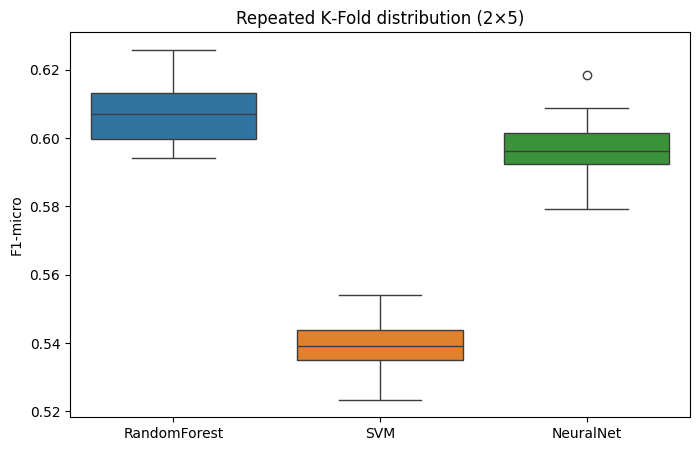

In [ ]:
# --- Summary & boxplot ---
print(df_scores.describe())

plt.figure(figsize=(8,5))
sns.boxplot(data=df_scores)
plt.ylabel('F1‑micro')
plt.title('Repeated K‑Fold distribution (2×5)')
plt.show()


In [ ]:
# --- Friedman + Wilcoxon ---
stat, p = friedmanchisquare(df_scores['RandomForest'],
                             df_scores['SVM'],
                             df_scores['NeuralNet'])
print(f'Friedman χ² = {stat:.4f}, p = {p:.4e}')

alpha = 0.05
if p < alpha:
    print('→ Significant differences ➜ Wilcoxon:')
    pairs = [('RandomForest','SVM'),
             ('RandomForest','NeuralNet'),
             ('SVM','NeuralNet')]
    for a,b in pairs:
        w, p_pair = wilcoxon(df_scores[a], df_scores[b])
        print(f'  {a} vs {b}: W={w:.1f}, p={p_pair:.4e}')
else:
    print('→ No significant differences (fail to reject H₀)')


Friedman χ² = 18.2000, p = 1.1167e-04
→ Significant differences ➜ Wilcoxon:
  RandomForest vs SVM: W=0.0, p=1.9531e-03
  RandomForest vs NeuralNet: W=2.0, p=5.8594e-03
  SVM vs NeuralNet: W=0.0, p=1.9531e-03


In [ ]:
df_scores.to_csv('models/repeated_kfold_scores.csv', index=False)
print('Saved per‑fold scores ➜ models/repeated_kfold_scores.csv')

Saved per‑fold scores ➜ models/repeated_kfold_scores.csv
